In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import interpolate
from math import log, cos, sin, atan2
pi = np.pi
np.set_printoptions(precision=3)

In [2]:
def createPeriodicSplines( X, Y ):
    tck, u = interpolate.splprep([X, Y], s=0, per=1)
    return tck

def createSplines( X, Y ):
    tck, u = interpolate.splprep([X, Y], s=0 )
    return tck

def computeNodeLocations( N, tck ):
    t = np.linspace( 0, 1, N )
    x, y = interpolate.splev(t, tck)
    return x, y

def computeNormParameterizationDerivative( N, tck ):
    t = np.linspace( 0, 1, N )
    dx_dt, dy_dt = interpolate.splev(t, tck, der=1)
    ds_dt = np.sqrt( dx_dt**2 + dy_dt**2 )
    return ds_dt

## this function I think is unnecessary but not sure
def computeRadial( N, tck ):
    t = np.linspace( 0, 1, N )
    rx, ry = interpolate.splev(t, tck)
    norm = np.sqrt( rx**2 + ry**2 )
    return rx/norm, ry/norm

def computeTangent( N, tck ):
    t = np.linspace( 0, 1, N )
    tx, ty = interpolate.splev(t, tck, der=1)
    norm = np.sqrt( tx**2 + ty**2 )
    return tx/norm, ty/norm

def computeNormal( N, tck ):
    t = np.linspace( 0, 1, N )
    nx, ny = interpolate.splev(t, tck, der=2)
    norm = -np.sqrt( nx**2 + ny**2 )
    return nx/norm, ny/norm

def computeBinormal( N, tck ):
    tx, ty = computeTangent( N, tck )
    nx, ny = computeNormal( N, tck )
    tangentVector = np.vstack( (tx, ty) )
    normalVector = np.vstack( (nx, ny) )
    binormal = np.cross( np.transpose(tangentVector), np.transpose(normalVector) )
    return -binormal

def computeCurvature( N, tck ):
    t = np.linspace( 0, 1, N )
    d1x, d1y = interpolate.splev(t, tck, der=1)
    d2x, d2y = interpolate.splev(t, tck, der=2)
    curvature = (d2x*d1y - d2y*d1x) / (d1x**2+d1y**2)**(3/2)
    return curvature

def computeChordLength( X ):
    return np.max(X) - np.min(X)

def computeAirfoilPseudoThickness( Y ):
    return np.max(Y) - np.min(Y)

def createWakeGeometry( X, Y, AOA ):
    chordLength = computeChordLength( X )
    wakeLength = 10 * chordLength
    x0 = .5 * ( X[0] + X[-1] )
    y0 = .5 * ( Y[0] + Y[-1] )
    xf = x0 + wakeLength * np.cos( AOA * pi/180 )
    yf = y0 + wakeLength * np.sin( AOA * pi/180 )
    Xw = np.asarray( [x0, xf] )
    Yw = np.asarray( [y0, yf] )
    tck, u = interpolate.splprep([Xw, Yw], k=1, s=0, quiet=True )
    return tck

def computeWakeNormal( Nw, AOA ):
    nxw = -np.sin( AOA * pi/180 ) * np.ones( Nw )
    nyw = np.cos( AOA * pi/180 ) * np.ones( Nw )
    return nxw, nyw
    

## functions for collocation points

In [3]:
def computeCollocationNodeLocations( N, tck ):
    t = np.linspace( 0, 1, N )
    t = (t[1:] + t[:-1])/2
    x, y = interpolate.splev(t, tck)
    return x, y

def computeCollocationTangent( N, tck ):
    t = np.linspace( 0, 1, N )
    t = (t[1:] + t[:-1])/2
    tx, ty = interpolate.splev(t, tck, der=1)
    norm = np.sqrt( tx**2 + ty**2 )
    return tx/norm, ty/norm

def computeCollocationNormal( N, tck ):
    t = np.linspace( 0, 1, N )
    t = (t[1:] + t[:-1])/2
    nx, ny = interpolate.splev(t, tck, der=2)
    norm = -np.sqrt( nx**2 + ny**2 )
    return nx/norm, ny/norm

def computeCollocationBinormal( N, tck ):
    tx, ty = computeCollocationTangent( N, tck )
    nx, ny = computeCollocationNormal( N, tck )
    tangentVector = np.vstack( (tx, ty) )
    normalVector = np.vstack( (nx, ny) )
    binormal = np.cross( np.transpose(tangentVector), np.transpose(normalVector) )
    return -binormal

## Some Helper Functions
1. readAirfoilData
2. processDat
3. plotAirfoil

In [4]:
def readAirfoilDat( airfoilName ):
    currentDir = os.path.abspath(os.getcwd())
    filepath = currentDir + "/" + airfoilName + ".dat"
    print( filepath )
    if os.path.exists(filepath):
        f = open(filepath, "r")
        airfoilDat = f.read()
        f.close()
        return airfoilDat
    else:
        print("The file does not exist")
        
def processDat( airfoilDat ):
    airfoilDat = (" ".join(airfoilDat.split())).split()
    N = len(airfoilDat)
    x = []
    y = []
    for i in range( 0, N, 2 ):
        x.append( float( airfoilDat[i] ) )
        y.append( float( airfoilDat[i+1] ) )
    id = y.index(max( y ))
    displacement = x[id]
    i = 0
    for xx in x:
        x[i] = x[i] - displacement
        i = i + 1    
    
    x = np.asarray(x)
    y = np.asarray(y)
    x = x.astype(np.float)
    y = y.astype(np.float)
    return x, y

def plotAirfoil( X, Y, N, airfoilName ):
    tck = createSplines( X, Y )
    x, y = computeNodeLocations( N+1, tck )
    C = computeChordLength( X )
    T = computeAirfoilPseudoThickness( Y )
    
    fig, ax = plt.subplots(figsize=(16, 32*T/C))
    plt.grid(b=True, which='major', linestyle='--', linewidth=.5)
    plt.grid(b=True, which='minor', linestyle='--', linewidth=.1)
    plt.minorticks_on()
    plt.xlabel(xlabel='x', fontsize=16)
    plt.ylabel(ylabel='y', fontsize=16)
    D = .75 * C
    ax.set_xlim([-D+np.mean(X), D+np.mean(X)])
    ax.set_ylim([-D*T/C, D*T/C])
    plt.title( airfoilName + " Geometry", fontsize=20)
    plt.plot( x, y, label="B-spline Representation")
    xc, yc = computeCollocationNodeLocations( N+1, tck )
    plt.plot( xc, yc, '*', markersize=10)
    
    

# Constant Strength Doublet Method

The quadrant (i.e., branch) is chosen so that arctan2(x1, x2) is the signed angle in radians between the ray ending at the origin and passing through the point (1,0), and the ray ending at the origin and passing through the point (x2, x1). (Note the role reversal: the “y-coordinate” is the first function parameter, the “x-coordinate” is the second.) By IEEE convention, this function is defined for x2 = +/-0 and for either or both of x1 and x2 = +/-inf (see Notes for specific values).

In [5]:
def ComputeAlpha( x1, y1, x2, y2 ):
    return atan2( -(y1-y2), -(x1-x2) )

print("ComputeAlpha")
print( ComputeAlpha( 1, 0, 0, 1) )
print( -pi/4 )
print("")
print( ComputeAlpha( 1, 0, 0, -1) )
print( pi/4 )
print("\n")

def GlobalToPanelCoords( x, y, x1, y1, x2, y2 ):
    alpha = ComputeAlpha( x1, y1, x2, y2 )
    
    ## first displace all points such that the coordinate system origin is on (x1, y1)
    xp = cos(alpha) * ( x - x1 ) + sin(alpha) * ( y - y1 )
    yp = -sin(alpha) * ( x - x1 ) + cos(alpha) * ( y - y1 )
    xp1 = 0 
    yp1 = 0 
    xp2 = cos(alpha) * ( x2 - x1 ) + sin(alpha) * ( y2 - y1 )
    yp2 = -sin(alpha) * ( x2 - x1 ) + cos(alpha) * ( y2 - y1 )
    
    return xp, yp, xp1, yp1, xp2, yp2, alpha

print("GlobalToPanelCoords")
print( GlobalToPanelCoords( 5, 3, 4, 1, 2, 2 ) )
print( "(", 0, -5**.5, 0, 0, 5**.5, 0, ")")
print("")
print( GlobalToPanelCoords( 3, -1, 4, 1, 2, 2 ) )
print( "(", 0, 5**.5, 0, 0, 5**.5, 0, ")")
print("\n")

  
def DUB2DC( x, y, x1, y1, x2, y2 ): ## given global coordinates
    ## transform from global coordinates to panel coordinates (coordinates)
    xp, yp, xp1, yp1, xp2, yp2, alpha = GlobalToPanelCoords( x, y, x1, y1, x2, y2 )
    
    ## compute induced velocity by the doublet (in panel coordinates)
    up = ( yp / ( (xp-xp1)**2 + yp**2 ) - yp / ( (xp-xp2)**2+yp**2 ) )/2/pi
    vp = -( (xp-xp1) / ( (xp-xp1)**2 + yp**2 ) - (xp-xp2) / ( (xp-xp2)**2+yp**2 ) )/2/pi
    
    ## transform from panel coordinates to global coordinates (velocity)
    c = cos(alpha); s = sin(alpha)
    u = c*up - s*vp; v = s*up + c*vp
    return u, v


print("DUB2DC")
u, v = DUB2DC(0, 0, 1, 0, -1, 0)
print(u, v)  
print( 0.0, 1/pi )
print("")
u, v = DUB2DC(0, 0, -1, 0, 1, 0)
print(u, v)  
print( 0.0, -1/pi )
print("")
u, v = DUB2DC(0, 0, 1/np.sqrt(2), -1/np.sqrt(2), -1/np.sqrt(2), 1/np.sqrt(2))
print(u, v)  
print( 1/pi/2**.5, 1/pi/2**.5 )




ComputeAlpha
2.356194490192345
-0.7853981633974483

-2.356194490192345
0.7853981633974483


GlobalToPanelCoords
(3.3306690738754696e-16, -2.23606797749979, 0, 0, 2.23606797749979, 3.3306690738754696e-16, 2.677945044588987)
( 0 -2.23606797749979 0 0 2.23606797749979 0 )

(-3.3306690738754696e-16, 2.23606797749979, 0, 0, 2.23606797749979, 3.3306690738754696e-16, 2.677945044588987)
( 0 2.23606797749979 0 0 2.23606797749979 0 )


DUB2DC
3.8981718325193755e-17 0.3183098861837907
0.0 0.3183098861837907

0.0 -0.3183098861837907
0.0 -0.3183098861837907

0.2250790790392766 0.22507907903927654
0.22507907903927651 0.22507907903927651


In [18]:
def ConstantStrengthDoubletMethod( X, Y, N, U0, AOA ):
    
    # generate geometry
    # for N panels we need N+1 points
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tck = createSplines( X, Y )
    x, y = computeNodeLocations( N+1, tck )
    tx, ty = computeTangent( N+1, tck )
    binormal = computeBinormal( N+1, tck )

    ## generate collocation point data
    xc = ( x[1:] + x[:-1] )/2; yc = ( y[1:] + y[:-1] )/2;
    panelAlpha = np.arctan2( np.diff(y), np.diff(x) )
    nxc = np.sin( panelAlpha )
    nyc = -np.cos( panelAlpha )
    
    ## generate wake geometry
    tckw = createWakeGeometry( X, Y, AOA )
    xw, yw = computeNodeLocations( N+1, tckw )
    
    # generate a (N+2)x(N+2) system of equations
    # where the last row is to apply the kutta-condition
    A = np.zeros( (N + 1, N+1) )
    b = np.zeros( N + 1 )
    
    ## row of matrix
    for i in range( N ):
        b[i] = -U0 * ( np.cos( AOA * pi / 180 ) * nxc[i] + np.sin( AOA * pi / 180 ) * nyc[i] )
        for j in range( N ):
            ## first panel point & second panel point
            u, v = DUB2DC( xc[i], yc[i], x[j], y[j], x[j+1], y[j+1] )
            A[i, j] = (u*nxc[i] + v*nyc[i])
            
            
    ## include wake effect
    for i in range( N ):
        for j in range( N ):
            u, v = DUB2DC( xc[i], yc[i], xw[j], yw[j], xw[j+1], yw[j+1] )
            A[i, -1] = A[i, -1] + (u*nxc[i] + v*nyc[i])
    
    ## include Kutta Condition
    A[N, 0] = 1; A[N, -2] = -1; A[N, -1] = 1     

    return A, b, x, y, xc, yc



/Users/daniellam/Google Drive/python/Boundary Integral Method/NACA0006.dat
[ 0.368  0.588  0.639  0.665  0.682  0.696  0.707  0.716  0.724  0.73
  0.736  0.741  0.746  0.75   0.754  0.758  0.761  0.764  0.767  0.77
  0.773  0.776  0.778  0.781  0.784  0.786  0.789  0.791  0.794  0.796
  0.799  0.801  0.803  0.806  0.808  0.811  0.814  0.816  0.819  0.822
  0.824  0.827  0.83   0.833  0.836  0.839  0.843  0.846  0.85   0.854
  0.858  0.862  0.867  0.872  0.878  0.884  0.891  0.899  0.909  0.922
  0.936  0.956  0.99   0.586 -0.32   0.352  0.474  0.542  0.582  0.606
  0.625  0.64   0.652  0.661  0.669  0.675  0.681  0.686  0.69   0.694
  0.697  0.7    0.703  0.705  0.707  0.709  0.711  0.712  0.714  0.715
  0.716  0.717  0.717  0.718  0.719  0.719  0.719  0.72   0.72   0.72
  0.72   0.72   0.72   0.72   0.72   0.719  0.719  0.718  0.717  0.716
  0.715  0.714  0.713  0.711  0.709  0.707  0.704  0.701  0.697  0.692
  0.686  0.679  0.67   0.658  0.641  0.616  0.562  0.317]


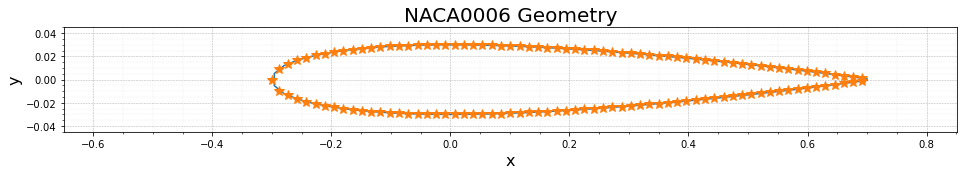

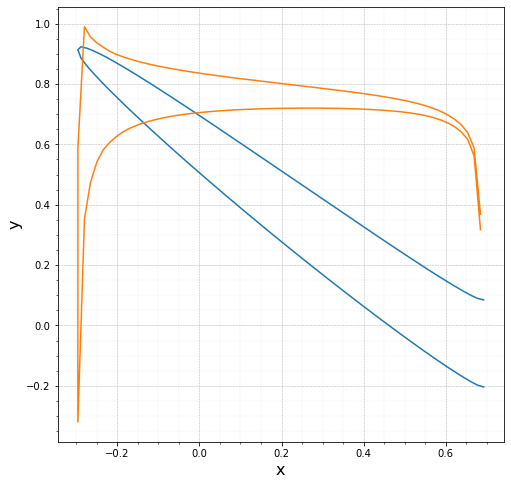

In [115]:
N = 129
U0 = 1
AOA = 5
airfoilName = "NACA0006"
airfoilDat = readAirfoilDat( airfoilName )
X, Y = processDat( airfoilDat )
Y = Y


plotAirfoil( X, Y, N, airfoilName )

A, b, x, y, xc, yc = ConstantStrengthDoubletMethod( X, Y, N, U0, AOA )
nu = np.linalg.solve( A, b )


fig, ax = plt.subplots(figsize=(8, 8))
plt.grid(b=True, which='major', linestyle='--', linewidth=.5)
plt.grid(b=True, which='minor', linestyle='--', linewidth=.1)
plt.minorticks_on()
plt.xlabel(xlabel='x', fontsize=16)
plt.ylabel(ylabel='y', fontsize=16)
nu = nu[:-1]
dnu = np.diff(nu)
dl = np.sqrt( (np.diff(xc)**2 + np.diff(yc)**2) )
q = .5*dnu/dl
theta = np.arctan2( np.diff(yc), np.diff(xc) )
tx = np.cos(theta)
ty = -np.sin(theta)
qt = tx*U0*np.cos(AOA*pi/180) + ty*U0*np.sin(AOA*pi/180)

cp = 1 - ((qt+q)/U0)**2

plt.plot( xc, nu )
plt.plot(x[1:-1], cp )
print( cp )




## Lift Coefficient vs Angle of Attack: Constant Strength Doublet Panel

/Users/daniellam/Google Drive/python/Boundary Integral Method/NACA0006.dat


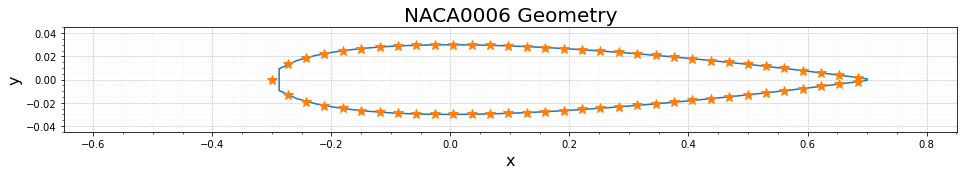

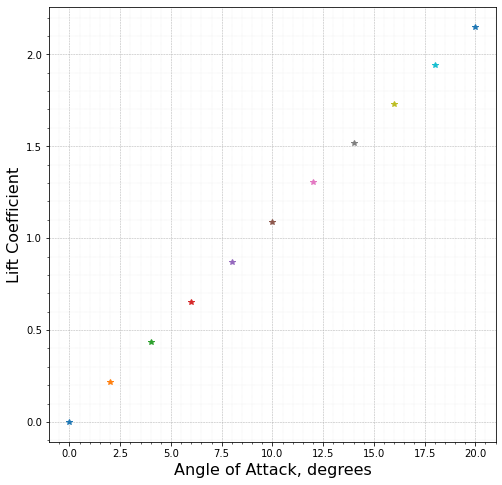

In [22]:
N = 65
U0 = 1
AOA = 5
airfoilName = "NACA0006"
airfoilDat = readAirfoilDat( airfoilName )
X, Y = processDat( airfoilDat )
Y = Y


plotAirfoil( X, Y, N, airfoilName )



fig, ax = plt.subplots(figsize=(8, 8))
plt.grid(b=True, which='major', linestyle='--', linewidth=.5)
plt.grid(b=True, which='minor', linestyle='--', linewidth=.1)
plt.minorticks_on()
plt.xlabel(xlabel='Angle of Attack, degrees', fontsize=16)
plt.ylabel(ylabel='Lift Coefficient', fontsize=16)
for AOA in range(0, 21, 2):
    A, b, x, y, xc, yc = ConstantStrengthDoubletMethod( X, Y, N, U0, AOA )
    nu = np.linalg.solve( A, b )
    L = nu[-1]
    CL = L/.5
    plt.plot( AOA, CL, '*' )





# Panel Methods based on the Dirichlet BC

This jupyter notebook implements panel methods based on Dirichlet BC:
2. Constant Source / Constant Doublet Method

1. Linear Source / Doublet Method
2. Linear Doublet Method
3. Linear Source / Quadratic Doublet Method
4. Quadratic Doublet Method


# 1. Constant-Strength Doublet Method

The velocity potential  at a point P due to a constant-strength doublet element is:
<center> $ \phi = -\frac{\mu}{2\pi} [tan^{-1}\frac{y}{x-x_2} - tan^{-1}\frac{y}{x-x_1}] $ </center>

In [10]:
def PHICD( x, y, x1, y1, x2, y2 ):
    ## transform from global coordinates to panel coordinates (coordinates)
    xp, yp, xp1, yp1, xp2, yp2, alpha = GlobalToPanelCoords( x, y, x1, y1, x2, y2 )
    
    ## compute induced velocity potential by the doublet element (in panel coordinates)
    phi = -( atan2( yp, (xp-xp2 ) ) - atan2( yp, (xp-xp1 ) ) )/2/pi
    return phi 

print("PHICD")
print("Taking the num limit to 0+ of phi")
phi = PHICD(0, 0+1e-12, 1, 0, -1, 0)
print( phi )  
print( 1/2 )
print("")
print("Taking the num limit to 0- of phi")
phi = PHICD(0, 0-1e-12, 1, 0, -1, 0)
print( phi )  
print( -1/2 )
print("")



PHICD
Taking the num limit to 0+ of phi
0.49999999999968164
0.5

Taking the num limit to 0- of phi
-0.49999999999968164
-0.5



In [103]:
def DirichletConstantStrengthDoubletMethod( X, Y, N, U0, AOA ):
    
    # generate geometry
    # for N panels we need N+1 points
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tck = createSplines( X, Y )
    x, y = computeNodeLocations( N+1, tck )
    dx = np.diff(x)
    dy = np.diff(y)
    panelLength = np.sqrt( dx**2 + dy**2 )

    ## generate collocation point data
    xc = ( x[1:] + x[:-1] )/2; yc = ( y[1:] + y[:-1] )/2;
    panelAlpha = np.arctan2( dy, dx )
    nxc = np.sin( panelAlpha )
    nyc = -np.cos( panelAlpha )
    
    ## displace collocation point inward by 0.05 of the panel length
    xc = xc - 0.05*panelLength*nxc; yc = yc - 0.05*panelLength*nyc;
    
    ## generate wake geometry
    tckw = createWakeGeometry( X, Y, AOA )
    xw, yw = computeNodeLocations( N+1, tckw )
    
    # generate a (N+2)x(N+2) system of equations
    # where the last row is to apply the kutta-condition
    A = np.zeros( (N + 1, N+1) )
    b = np.zeros( N + 1 )
    
    ## row of matrix
    for i in range( N ):
        b[i] = U0 * ( xc[i] * np.cos( AOA * pi / 180 ) + yc[i] * np.sin( AOA * pi / 180 ) )
        for j in range( N ):
            ## first panel point & second panel point
            phi = PHICD( xc[i], yc[i], x[j], y[j], x[j+1], y[j+1] )
            A[i, j] = phi
            
            
    ## include wake effect
    for i in range( N ):
        for j in range( N ):
            phi = PHICD( xc[i], yc[i], xw[j], yw[j], xw[j+1], yw[j+1] )
            A[i, -1] = A[i, -1] + phi
    
    ## include Kutta Condition
    A[N, 0] = 1; A[N, -2] = -1; A[N, -1] = 1     

    return A, b, x, y, xc, yc




/Users/daniellam/Google Drive/python/Boundary Integral Method/NACA0006.dat


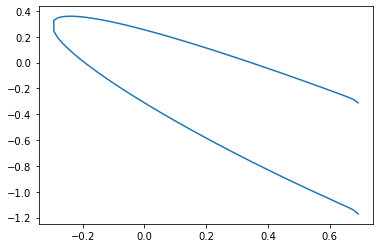

In [104]:
N = 128
U0 = 1
AOA = 15
airfoilName = "NACA0006"
airfoilDat = readAirfoilDat( airfoilName )
X, Y = processDat( airfoilDat )
Y = Y

A, b, x, y, xc, yc = DirichletConstantStrengthDoubletMethod( X, Y, N, U0, AOA )
phi = np.linalg.solve( A, b )
phi = phi[:-1]
plt.plot( xc, phi )


/Users/daniellam/Google Drive/python/Boundary Integral Method/NACA0006.dat


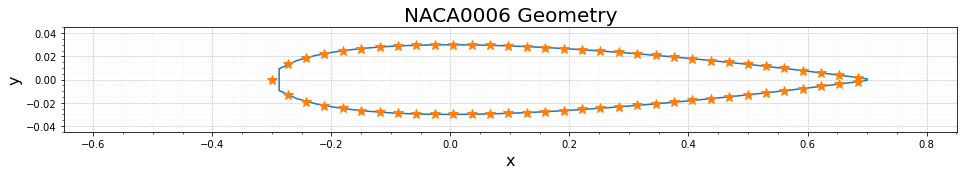

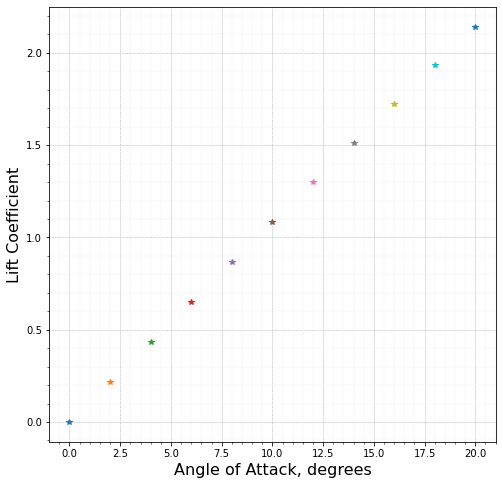

In [105]:
N = 65
U0 = 1
AOA = 5
airfoilName = "NACA0006"
airfoilDat = readAirfoilDat( airfoilName )
X, Y = processDat( airfoilDat )
Y = Y


plotAirfoil( X, Y, N, airfoilName )



fig, ax = plt.subplots(figsize=(8, 8))
plt.grid(b=True, which='major', linestyle='--', linewidth=.5)
plt.grid(b=True, which='minor', linestyle='--', linewidth=.1)
plt.minorticks_on()
plt.xlabel(xlabel='Angle of Attack, degrees', fontsize=16)
plt.ylabel(ylabel='Lift Coefficient', fontsize=16)
for AOA in range(0, 21, 2):
    A, b, x, y, xc, yc = DirichletConstantStrengthDoubletMethod( X, Y, N, U0, AOA )
    nu = np.linalg.solve( A, b )
    L = nu[-1]
    CL = L/.5
    plt.plot( AOA, CL, '*' )






# 2. Constant Source / Constant Doublet Method

The velocity potential at a point P due to a constant-strength source element is:
<center> $ \phi = \frac{ \sigma }{ 4 \pi } \{(x-x_1)ln[(x-x_1)^2+y^2] - (x-x_2)ln[(x-x_2)^2+y^2] + 2z(tan^{-1}\frac{y}{x-x_2} - tan^{-1}\frac{y}{x-x_1}) \} $ </center>

The velocity potential  at a point P due to a constant-strength doublet element is:
<center> $ \phi = -\frac{\mu}{2\pi} [tan^{-1}\frac{y}{x-x_2} - tan^{-1}\frac{y}{x-x_1}] $ </center>



In [ ]:
def PHICS( x, y, x1, y1, x2, y2 ):
    ## transform from global coordinates to panel coordinates (coordinates)
    xp, yp, xp1, yp1, xp2, yp2, alpha = GlobalToPanelCoords( x, y, x1, y1, x2, y2 )
    
    ## compute induced velocity potential by the source element (in panel coordinates)
    phi = ( ( xp-xp1 )*log( ( xp-xp1 )**2 + yp**2 )\
          - ( xp-xp2 )*log( ( xp-xp2 )**2 + yp**2 )\
          + 2*yp*( atan2( yp, (xp-xp2 ) ) - atan2( yp, (xp-xp1 ) ) ) )/4/pi
    return phi

def PHICD( x, y, x1, y1, x2, y2 ):
    ## transform from global coordinates to panel coordinates (coordinates)
    xp, yp, xp1, yp1, xp2, yp2, alpha = GlobalToPanelCoords( x, y, x1, y1, x2, y2 )
    
    ## compute induced velocity potential by the doublet element (in panel coordinates)
    phi = -( atan2( yp, (xp-xp2 ) ) - atan2( yp, (xp-xp1 ) ) )/2/pi
    return phi 


print("PHICS")
ds = 1e-8
phi0 = PHICS(0, 0, 1, 0, -1, 0)
phi1 = PHICS(0, 0+ds, 1, 0, -1, 0)
phi2 = PHICS(0, 0-ds, 1, 0, -1, 0)
print("Obtaining the num limit to 0+ of u")
print( (phi1-phi0)/ds )
print( .5 )
print("Obtaining the num limit to 0+ of u")
print( (phi0-phi2)/ds )
print( -.5 )
print("\n")

print("PHICD")
print("Taking the num limit to 0+ of phi")
phi = PHICD(0, 0+1e-12, 1, 0, -1, 0)
print( phi )  
print( 1/2 )
print("")
print("Taking the num limit to 0- of phi")
phi = PHICD(0, 0-1e-12, 1, 0, -1, 0)
print( phi )  
print( -1/2 )
print("")






In [ ]:
def ConstantStrengthSourceAndConstantStrengthDoubletMethod( X, Y, N, U0, AOA ):
    
    # generate geometry
    # for N panels we need N+1 points
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tck = createSplines( X, Y )
    x, y = computeNodeLocations( N+1, tck )
    tx, ty = computeTangent( N+1, tck )
    binormal = computeBinormal( N+1, tck )

    ## generate collocation point data
    xc, yc = computeCollocationNodeLocations( N+1, tck )
    xc = ( x[1:] + x[:-1] )/2; yc = ( y[1:] + y[:-1] )/2; 
    txc, tyc = computeCollocationTangent( N+1, tck )
    nxc, nyc = computeCollocationNormal( N+1, tck )
    binormalc = computeCollocationBinormal( N+1, tck )
    
    ## generate wake geometry
    tckw = createWakeGeometry( X, Y, AOA )
    xw, yw = computeNodeLocations( N+1, tckw )
    
    ## correct normal direction
    nxc = binormalc * nxc
    nyc = binormalc * nyc
    alphita = np.arctan2( np.diff(y), np.diff(x) )
    nx = np.sin(alphita)
    ny = -np.cos(alphita)
    
    # generate a (N+2)x(N+2) system of equations
    # where the last row is to apply the kutta-condition
    A = np.zeros( (N + 1, N+1) )
    b = np.zeros( N + 1 )
    
    ## row of matrix
    for i in range( N ):
        b[i] = -U0 * ( np.cos( AOA * pi / 180 ) * nxc[i] + np.sin( AOA * pi / 180 ) * nyc[i] )
        for j in range( N ):
            ## first panel point & second panel point
            u, v = DUB2DC( xc[i], yc[i], x[j], y[j], x[j+1], y[j+1] )
            A[i, j] = (u*nxc[i] + v*nyc[i])
            
            
    ## include wake effect
    for i in range( N ):
        for j in range( N ):
            u, v = DUB2DC( xc[i], yc[i], xw[j], yw[j], xw[j+1], yw[j+1] )
            A[i, -1] = A[i, -1] + (u*nxc[i] + v*nyc[i])
    
    ## include Kutta Condition
    A[N, 0] = 1; A[N, -2] = -1; A[N, -1] = 1     

    return A, b, x, y, xc, yc


